In [1]:
# Import required libraries
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #Corrects crashing issues in windows

import numpy as np
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
# from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils1 import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle

# Set random seed for consistency
np.random.seed(5)

In [2]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Motor
# Note: motor[0] is the driving node and motor[1] is being driven around Motor[0]
motor = np.array([0,2])

In [3]:
# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

In [4]:
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_point_cloud, N = 5):
        self.N = N
        variables = dict()


        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
        for i in range(N):
            variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.tpc = target_point_cloud


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target node value
        target = x["target"]


        # Reshape flattened position matrix to its proper Nx2 shape
        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
        fixed_nodes = np.array([0,1])

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,2])

        return target, x0, fixed_nodes, motor


    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        target, x0, fixed_nodes, motor = self.convert_1D_to_mech(x)

        #Call our evaluate function to get validity, CD, and material use
        valid, CD, mat, _ = evaluate_mechanism(x0, fixed_nodes, motor, self.tpc, idx=target, device='cpu',timesteps=2000)

        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf, np.Inf]
        else:
            out["F"] = [CD,mat]

            # Set constraints as CD<=0.1 and Material<=10
            # Be careful about modifying these - designs that
            # violate the problem constraints will not be scored.
            out["G"] = [CD - 0.1, mat - 10]




Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 5 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

(-0.024300000000000002, 0.5103, -0.0035000000000000005, 0.07350000000000001)

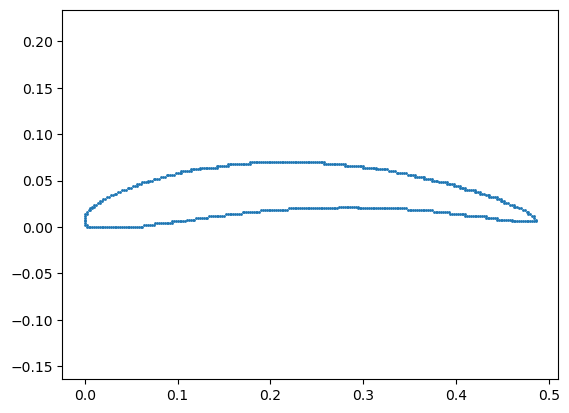

In [5]:
# Get target curve 0 and plot
target_index = 0
target_curve = np.array(target_curves[target_index])
plt.scatter(target_curve[:,0],target_curve[:,1],s=1)
plt.axis('equal')

In [6]:
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# Setup Problem
problem = mechanism_synthesis_optimization(target_curve,5)


# Set up GA with pop size of 100 -- see pymoo docs for more info on these settings!
algorithm = NSGA2(pop_size=1000, sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),)
#                   crossover=SBX(eta=40, prob=0.9),
#                   mutation=PM(eta=40))


# Run for 100 generations -- see pymoo docs for more info on these settings!
results = minimize(problem,
                   algorithm,
                   ('n_gen', 10),
                   verbose=True,
                   save_history=True,
                   seed=0)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |      2 |  0.000000E+00 |           INF |             - |             -
     2 |     2000 |      6 |  0.000000E+00 |           INF |  0.1627773617 |         ideal
     3 |     3000 |      5 |  0.000000E+00 |           INF |  0.0919957665 |         ideal
     4 |     4000 |      9 |  0.000000E+00 |  0.1697111663 |  0.0192185690 |         ideal
     5 |     5000 |      9 |  0.000000E+00 |  0.1164331460 |  0.0044833193 |         ideal
     6 |     6000 |     10 |  0.000000E+00 |  0.0766910983 |  0.0189292894 |             f
     7 |     7000 |     10 |  0.000000E+00 |  0.0340380692 |  0.1942958688 |         ideal
     8 |     8000 |      9 |  0.000000E+00 |  0.0130933716 |  0.0204728434 |             f
     9 |     9000 |     10 |  0.000000E+00 |  0.0005188229 |  0.1451758491 |         ideal
    10 |    10000 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0045216652 |         ideal

Pymoo automatically saves the optimal set of solutions and their corresponding performance. <code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions). The constraints that we specify in the problem guidelines are used as a reference point for hypervolume calculations which we will use to measure your submissions performance.

Hyper Volume ~ 0.677193


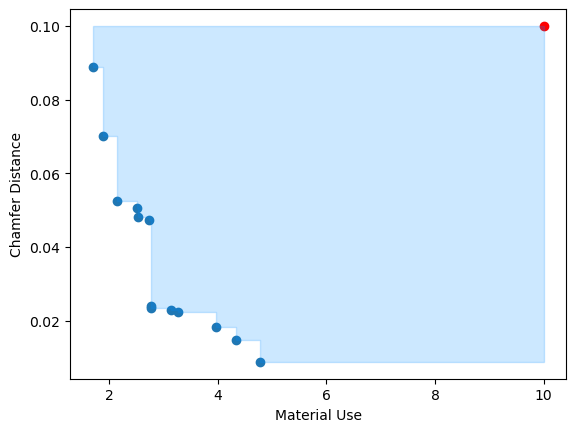

In [7]:
from pymoo.indicators.hv import HV

def plot_HV(F, ref):

    #Plot the designs
    plt.scatter(F[:,1],F[:,0])

    #plot the reference point
    plt.scatter(ref[1],ref[0],color="red")

    #plot labels
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')

    #sort designs and append reference point
    sorted_performance = F[np.argsort(F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[ref]])

    #create "ghost points" for inner corners
    inner_corners = np.stack([sorted_performance[:,0], np.roll(sorted_performance[:,1], -1)]).T

    #Interleave designs and ghost points
    final = np.empty((sorted_performance.shape[0]*2, 2))
    final[::2,:] = sorted_performance
    final[1::2,:] = inner_corners

    #Create filled polygon
    plt.fill(final[:,1],final[:,0],color="#008cff",alpha=0.2)

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.1, 10])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    plot_HV(results.F, ref_point)
else:
    print('Did Not Find Solutions!!')

Now lets plot the results for the best chamfer distance solution

In [8]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,0])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

In [9]:
fixed_nodes

array([0, 1])

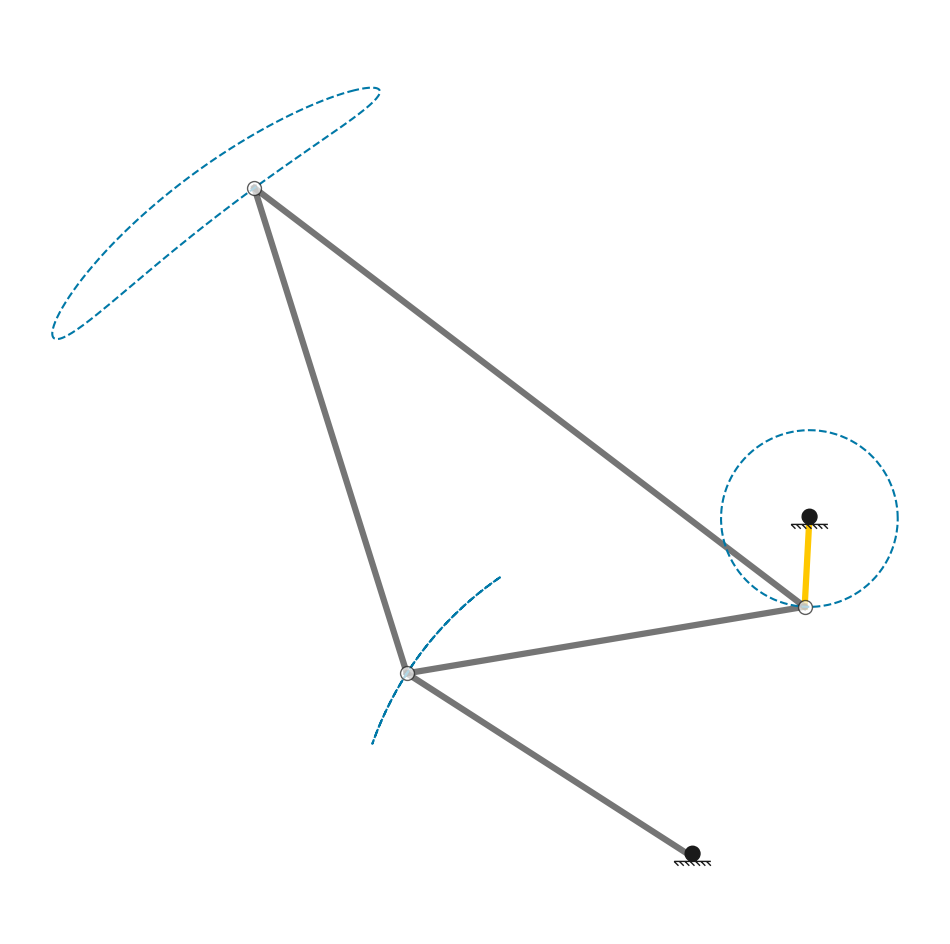

In [10]:
if not results.X is None:
    # Step 1: Reshape
    target, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)
    # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)

else:
    print('Did Not Find Solutions!!')

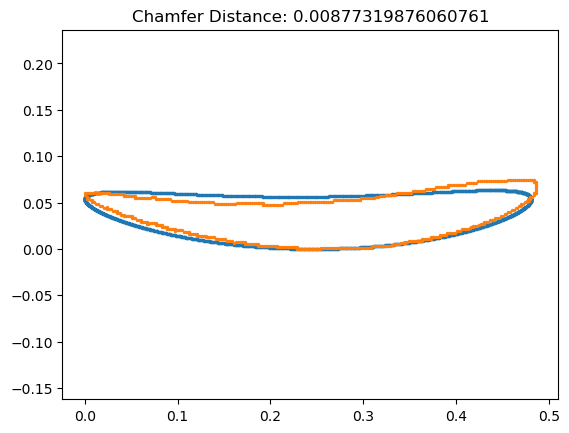

In [11]:
def comparecurves(x, fixed_nodes, motor, target, target_pc):
    valid, CD, mat, sol = evaluate_mechanism(x,fixed_nodes, motor, target_pc, idx=target,device='cpu',timesteps=2000)
    target_pc = get_oriented(target_pc)
    plt.scatter(sol[:,0],sol[:,1],s=2)
    plt.scatter(target_pc[:,0],target_pc[:,1],s=2)
    plt.title(f"Chamfer Distance: {CD}")
    plt.axis('equal')
if not results.X is None:
    comparecurves(x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')


Now lets see the solution with the least material use

In [12]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,1])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

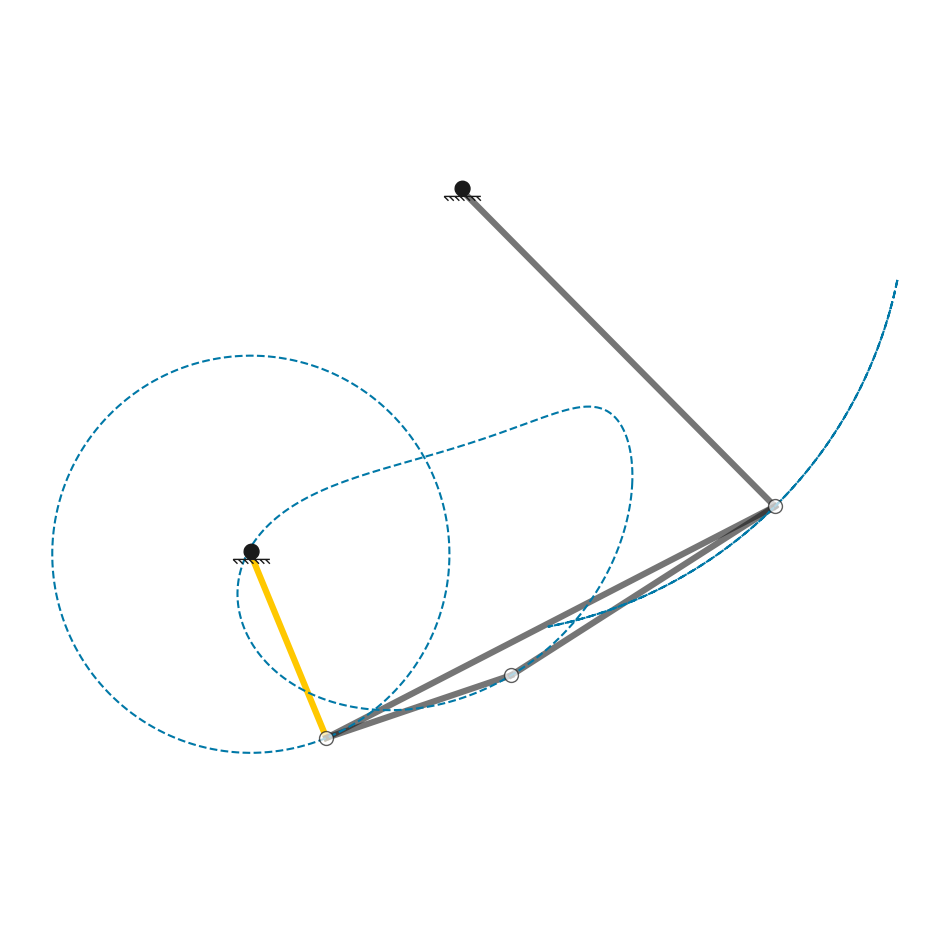

In [13]:
if not results.X is None:
    # Step 1: Reshape
    target, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)

    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)
else:
    print('Did Not Find Solutions!!')

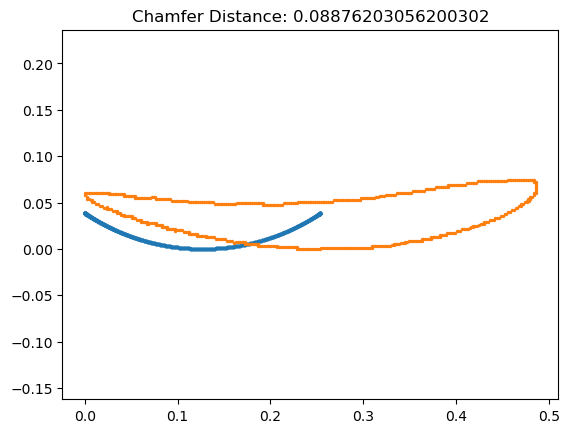

In [14]:
if not results.X is None:
    comparecurves(x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')

  0%|          | 0/13 [00:00<?, ?it/s]

ValueError: cannot reshape array of size 0 into shape (5,2)

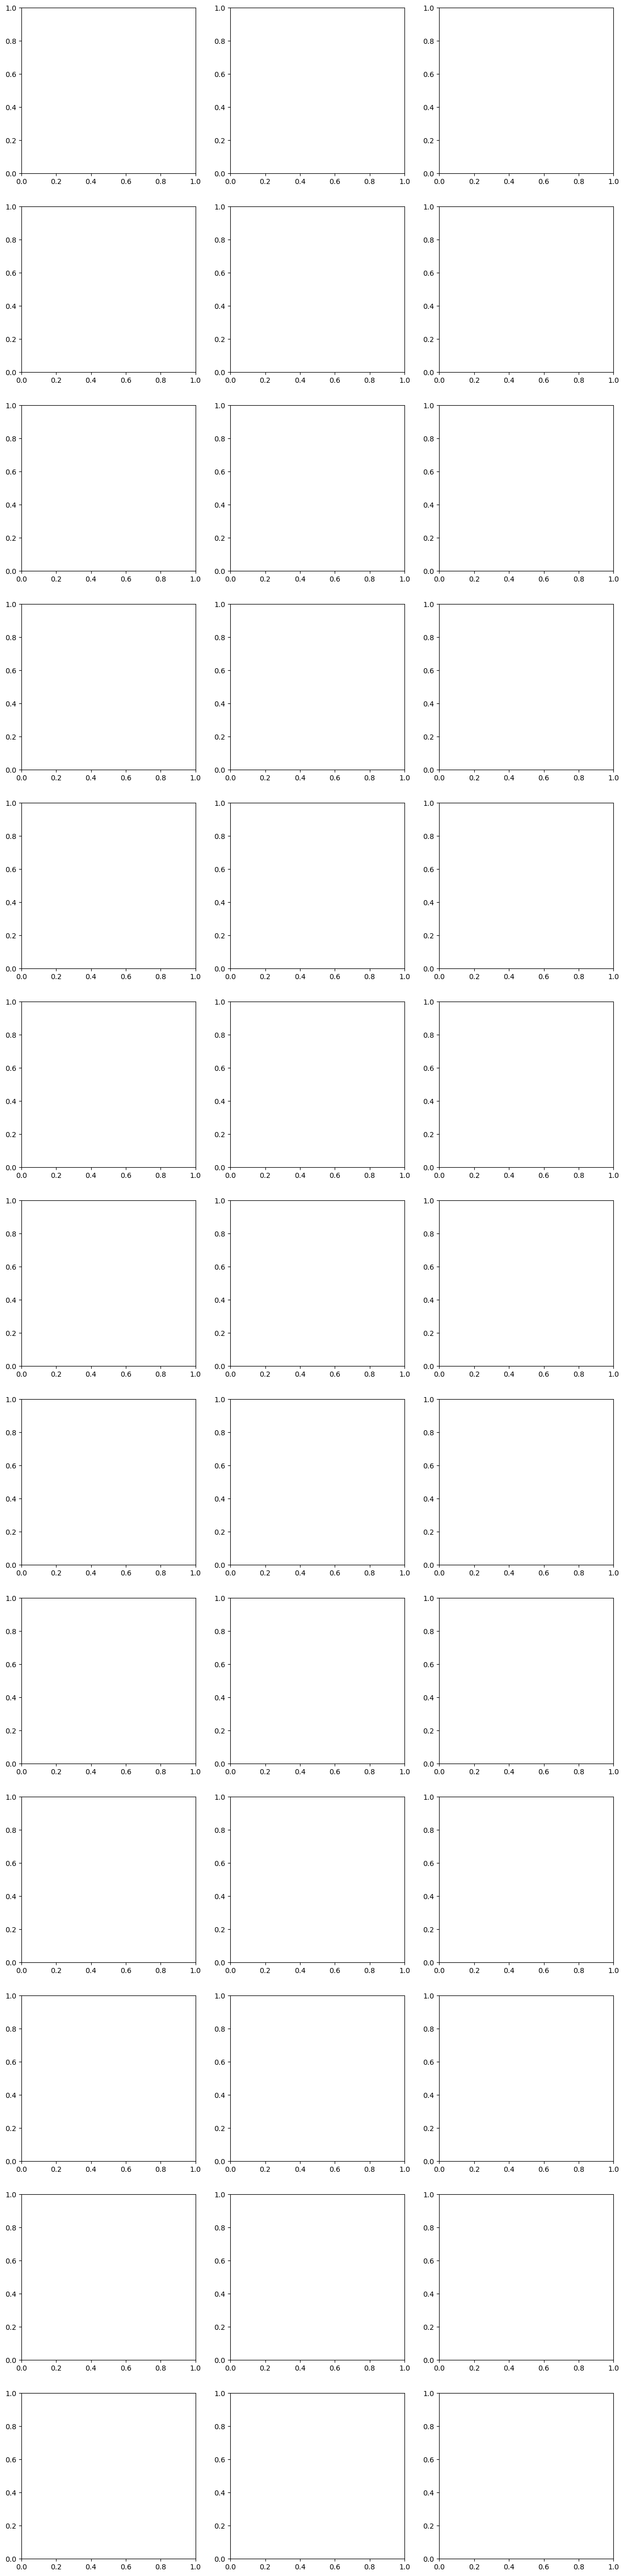

In [15]:
if not results.X is None:
    # first get generalized 1D representation
    mechanisms = []

    for x in results.pop.get("X"):
        target, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
        mechanisms.append(to_final_representation(x0,fixed_nodes,motor,target))
    # Visualize Pareto Front
    visualize_pareto_front(np.array(mechanisms),results.pop.get("F"),target_curve)
else:
    print('Did Not Find Solutions!!')